In [1]:
import sys
import os

sys.path.append('/import/silo2/aloe8475/Documents/edamame') #point to edamame locally
sys.path.append('/import/silo2/aloe8475/Documents/CODE/Analysis/Training/Associative Learning/EquilProp') #point to edamame locally

#Choose which nw:
nwChoice=700 #350 or 700

if nwChoice == 350:
    fileName='/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00'
elif nwChoice == 700:
    fileName='/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00698_nj_02582_seed_002_avl_10.00_disp_01.00_lx_75.00_ly_75.00'

#point to network data path ^ 

saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Equil Prop/' 
dataLoc='/import/silo2/aloe8475/Documents/Data/Associative Learning/EquilProp/'

#import edamame (neuromorphic nanowire python package by Ruomin Zhu)
from edamame import * 
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import loadmat, savemat
import networkx as nx
from tqdm.notebook import tqdm_notebook as tqdm
from IPython.core.debugger import set_trace

import pickle 
import _pickle as cPickle
import gzip

from learning_functions import genGridNW,point_on_line,dist
from learning_functions import calc_cost,setupStimulus,setupSourcesOnly,runTesting,getNWState,calcOutputs

2022-07-14 14:02:45,739:INFO:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [2]:

" Load Networks "
def buildNetworks(fileName,ManualSources=True,numDrains=2,numSources=9):
    #load data
    nw=loadmat(fileName)
    nwSize = nw['number_of_wires'][0][0]
    nwJunctions=nw['number_of_junctions'][0][0]
    print('Network '+str(nwSize)+ ' Loaded')
#     this_seed=8639
    Network=nw
    connectivity=connectivity__(wires_dict=Network) 

    #fixing file structure from Matlab:
    connectivity.avg_length=connectivity.avg_length[0][0]
    connectivity.number_of_junctions=connectivity.number_of_junctions[0][0]
    connectivity.centroid_dispersion=connectivity.centroid_dispersion[0][0]
    connectivity.dispersion=connectivity.dispersion[0][0]
    # connectivity.generating_number_of_wires=connectivity.generating_number_of_wires[0][0]
    connectivity.gennorm_shape=connectivity.gennorm_shape[0][0]
    connectivity.length_x=connectivity.length_x[0][0]
    connectivity.length_y=connectivity.length_y[0][0]
    connectivity.number_of_wires=connectivity.number_of_wires[0][0]
    connectivity.numOfWires=connectivity.numOfWires[0][0]
    connectivity.numOfJunctions=connectivity.numOfJunctions[0][0]
    connectivity.theta=connectivity.theta[0][0]
    connectivity.this_seed=connectivity.this_seed[0][0]
    
    #find x and y values of each end of each wire 
    xa=connectivity.xa[0]
    xb=connectivity.xb[0]
    ya=connectivity.ya[0]
    yb=connectivity.yb[0]

    #Pick Electrode placement/distance apart:
    
    #DRAINS
#     numDrains=7
    ex=np.zeros(numDrains)*5#*15
    if nwSize > 500:
        eyVal=76
    else:
        eyVal= 51
    ey=np.linspace(-1,eyVal,numDrains)#(-1,101,numDrains)

    elecDrain=genGridNW(xa,xb,ya,yb,ex,ey) #generate drain locations in ex, ey coordinates


    #IN A LINE:
    if nwSize > 500:
        exVal=75
        eyVal = 74
    else:
        exVal=50
        eyVal=49
    ex=np.ones(numSources)*exVal#50
    ey=np.linspace(-2,eyVal,numSources)#(-2,99,numSources)
    
    #IN A 3X3 GRID:
    # middleNWx=int(connectivity.length_x/2)+1
    # middleNWy=int(connectivity.length_y/2)-1
    # distBwElecs=10
    # ex=[middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx,middleNWx,middleNWx,middleNWx+distBwElecs,middleNWx+distBwElecs,middleNWx+distBwElecs]
    # ey=[middleNWy-distBwElecs,middleNWy,middleNWy+distBwElecs]*3

    elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates

    #Manual Source Placement:
    if ManualSources:
        if numSources==9:
            if nwSize > 500:
                elecSource=[678, 260, 491, 173, 628, 424, 301, 236, 483] #700nws
            else:
                elecSource=[23,320,194,74, 145, 317, 129, 34, 141] #350 nws

        elif numSources == 4:
            elecSource=[320,42,161,141]

#     elecDrain=elecDrain[[0,-1]]
    
    return connectivity,elecSource,elecDrain,nwSize,nwJunctions

In [3]:
#Generate 9 random 3x3 patterns:
def generatePatterns(numSamples=40,nback=9):
    pattern=[]
    K = 3
    N = 9

    arr=np.array([1]*K + [0] * (N-K))
    for p in range(nback):
        np.random.shuffle(arr)
        pattern.append(arr.copy())
    target=pattern[0]
    orig_inputs=np.array(pattern).astype('double')
    targets=list(range(1,nback+1))
    
    return orig_inputs,targets

#This function runs each training epoch and saves the network state at the last timestep of that epoch   
def getNWState_backprop(training_stimulus,train,state,drains,sources,tmpTiming,tmpTargets,limVal,allVals,run_time=2,dt=0.01,disable_tqdm=False):
    if train:
        #remove non-target drain from simulation
        target = tmpTargets[0]
        drains=drains[target-1]
        print('\nDrain '+str(target)+ ' Only')

    else:
        print('\nAll Drains')
    eles = np.append(drains, sources) #all drains
    #     if len(eles) == num_drain_training + num_source_training:
    training_sim,cost = runSim_backprop(connectivity, 
                                   stimulus = training_stimulus,
                                   junctionMode = 'tunneling',
                                   dt = dt, T = run_time, 
                                   contactMode = 'preSet',
                                   electrodes = eles,
                                   findFirst = False,
                                   start_state = state,
                                   disable_tqdm=disable_tqdm,
                                   collapse=False,tmpTiming=tmpTiming,tmpTargets=tmpTargets,
                                   limVal=limVal,allVals=allVals)  
    JS1 = getJunctionState(training_sim, -1) #save state
    #     else: 
    #         print('Bless you Joel :)')
    return training_sim,JS1   

#Combine drain voltage change with runSim:
def runSim_backprop(Connectivity, 
                    junctionMode='binary', collapse=False,
                    criticalFlux=0.1, maxFlux=1.5e-1,
                    contactMode='farthest', electrodes=None,
                    dt=1e-3, T=10, 
                    stimulus = None,
                    biasType = 'DC',
                    onTime=0, offTime=50000000,
                    onAmp=1, offAmp=0.005,
                    f = 1, customSignal = None,
                    start_state = None,
                    lite_mode = False, save_steps = 1,
                    findFirst = True,
                    disable_tqdm = False,
                    freeze_wire = None, freeze_junction = None, 
                    freeze_TimeStamp = None,tmpTiming=[],tmpTargets=[],
                    limVal=0.5,allVals=[]):

    """
    For the case of multi electrodes, stimulus should be in parameters.
    See help(stimulus__) for how to generate stimulus__ objects.
    """

    SimulationOptions = simulationOptions__(dt = dt, T = T,
                                            connectivity = Connectivity, 
                                            contactMode = contactMode,
                                            electrodes = electrodes)

    if ((contactMode == 'preSet') and (len(electrodes) > 2)) or stimulus is not None:
        from sys import exit
        if stimulus == None:
            logging.warning(f'Multiple electrodes detected. Please input stimulus in parameters!')
            exit()
        if len(stimulus) < len(SimulationOptions.electrodes):
            diff = len(SimulationOptions.electrodes) - len(stimulus)
            for _ in range(diff):
                stimulus.append(stimulus__('Drain', T = T, dt = dt))

        if len(stimulus) > len(SimulationOptions.electrodes):
            logging.warning(f'More stimulus than electrodes. Current setup has {len(SimulationOptions.electrodes)} electrodes!')
            exit()
            
        if len(stimulus[0].signal) < len(SimulationOptions.TimeVector):
            logging.warning(f'Stimulus length not correct, current time vector has length {len(SimulationOptions.TimeVector)}!')
            exit()
        SimulationOptions.stimulus = stimulus
            
    elif contactMode == 'boundary':
        SimulationOptions.stimulus[:int(len(SimulationOptions.electrodes)/2)] = [stimulus__(biasType = biasType, 
                                                                                        T = T, dt = dt,
                                                                                        onTime = onTime, offTime = offTime,
                                                                                        onAmp = onAmp, offAmp = offAmp,
                                                                                        f = f, customSignal= customSignal)
                                                                                        for i in range(int(len(SimulationOptions.electrodes)/2))]
    else:
        SimulationOptions.stimulus[0] = stimulus__(biasType = biasType, 
                                                T = T, dt = dt,
                                                onTime = onTime, offTime = offTime,
                                                onAmp = onAmp, offAmp = offAmp,
                                                    f = f, customSignal= customSignal)
    if start_state == None: 
        JunctionState = junctionState__(Connectivity.numOfJunctions, 
                                    mode = junctionMode, collapse = collapse, 
                                    criticalFlux=criticalFlux, maxFlux = maxFlux)
    else:
        from copy import deepcopy
        JunctionState = deepcopy(start_state)
    
    kwdict = dict()
    if (freeze_wire != None) or (freeze_junction != None):
        kwdict = dict(freeze_wire = freeze_wire,
                    freeze_junction = freeze_junction, 
                    freeze_TimeStamp = freeze_TimeStamp)
        
    this_realization,cost = simulateNetwork_backprop(SimulationOptions, Connectivity, JunctionState,tmpTiming,tmpTargets,limVal,allVals,lite_mode, disable_tqdm, save_steps, **kwdict)
    
    # if we stop simulation at theta, use this code. otherwise we reset voltages to 0 instead
    
#     finalIter=np.max(np.nonzero(this_realization.electrodeCurrent))
#     if finalIter < 199:
#         this_realization.electrodeCurrent=this_realization.electrodeCurrent[:finalIter+1,:]
#         this_realization.junctionVoltage=this_realization.junctionVoltage[:finalIter+1,:]
#         this_realization.junctionConductance=this_realization.junctionConductance[:finalIter+1,:]
#         this_realization.wireVoltage=this_realization.wireVoltage[:finalIter+1,:]
#         this_realization.filamentState=this_realization.filamentState[:finalIter+1,:]
#         this_realization.junctionSwitch=this_realization.junctionSwitch[:finalIter+1,:]
        #final Iter = time , use that to find / save network state
        
        
#         this_realization.TimeVector=this_realization.TimeVector[:finalIter+1,:]

    #     remove zeros from simulations that ended early:
#     this_realization.junctionCurrent
    
    if findFirst:
        from edamame.analysis.GraphTheory import findCurrent
        try:
            activation = findCurrent(this_realization, 1)
            logging.info(f'First current path {activation[0][0]} formed at time = {activation[1][0]} s.')
        except:
            logging.info('Unfortunately, no current path is formed in simulation time.')

    return this_realization,cost

def simulateNetwork_backprop(simulationOptions, connectivity, junctionState,tmpTiming,tmpTargets, limVoltage,allVals,lite_mode = False, disable_tqdm = False, save_steps = 1, **kwargs):
    niterations = simulationOptions.NumOfIterations
    electrodes = simulationOptions.electrodes
    numOfElectrodes = len(electrodes)
    E = connectivity.numOfJunctions
    V = connectivity.numOfWires
    edgeList = connectivity.edge_list
    cost      = []

#     onAmp     = simulationOptions.stimulus[3].onAmp
    
#     maxV      = onAmp *limVoltage
    
    Network = network__()
    sampling = np.arange(0, niterations, save_steps)
    if lite_mode:
        Network.connectivity = connectivity__(adjMat = connectivity.adj_matrix)
        Network.filamentState = np.zeros((int(niterations/save_steps), E))
        Network.wireVoltage = np.zeros((int(niterations/save_steps), V))
        Network.electrodeCurrent = np.zeros((int(niterations/save_steps), numOfElectrodes))
        Network.TimeVector = np.zeros(int(niterations/save_steps))
    else:        
        Network.connectivity = connectivity
        Network.TimeVector = simulationOptions.TimeVector
        Network.filamentState = np.zeros((niterations, E))
        Network.junctionVoltage = np.zeros((niterations, E))
        # Network.junctionResistance = np.zeros((niterations, E))
        Network.junctionConductance = np.zeros((niterations, E))
        Network.junctionSwitch = np.zeros((niterations, E), dtype = bool)
        Network.wireVoltage = np.zeros((niterations, V))
        Network.electrodeCurrent = np.zeros((niterations, numOfElectrodes))

    Network.sources = []
    Network.drains = []
    for i in range(numOfElectrodes):
        if np.mean(simulationOptions.stimulus[i].signal) != 0:
            Network.sources.append(electrodes[i])
        else:
            Network.drains.append(electrodes[i])

    if len(Network.drains) == 0:
        Network.drains.append(electrodes[1])
        
    if 'freeze_wire' in kwargs:
        freeze_wire = kwargs['freeze_wire']
        freeze_TimeStamp = kwargs['freeze_TimeStamp']
    else:
        freeze_TimeStamp = niterations + 1
    
    
    stopTrain=False
    for this_time in tqdm(range(niterations), desc='Running Simulation ', disable = disable_tqdm): #each time step
        if not stopTrain: #if training and reached theta or testing
            this_stimulus = np.array([i.signal[this_time] for i in simulationOptions.stimulus])
#         else:
#             break
        if tmpTiming[this_time]=='Train':
            trainTime=True
            
        elif tmpTiming[this_time]=='Test':

            trainTime=False

        if trainTime and this_time > 0 and not stopTrain: #if we are training, change drain voltages, otherwise just use this_stimulus
            
            this_stimulus[:num_drain_training]=new_stimulus

        #run sim   
        sol = simCore(connectivity, junctionState, this_stimulus, electrodes, simulationOptions.dt)

        if this_time >= freeze_TimeStamp:
            others = np.setdiff1d(range(V), freeze_wire)
            wireVoltage[others] = sol[others]
        else:
            wireVoltage = sol[0:V]

        if lite_mode:
            if this_time%save_steps == 0:
                Network.wireVoltage[this_time//save_steps,:] = wireVoltage
                Network.electrodeCurrent[this_time//save_steps,:] = sol[V:]
                Network.filamentState[this_time//save_steps,:] = junctionState.filamentState
                Network.TimeVector[this_time//save_steps] = simulationOptions.TimeVector[this_time]
        else:
            Network.wireVoltage[this_time,:] = wireVoltage
            Network.electrodeCurrent[this_time,:] = sol[V:]
            Network.filamentState[this_time,:] = junctionState.filamentState
            Network.junctionVoltage[this_time,:] = junctionState.voltage
            Network.junctionConductance[this_time,:] = junctionState.conductance
            Network.junctionSwitch[this_time,:] = junctionState.OnOrOff

        ## BackProp Implementation
        if trainTime:
            n = num_drain_training #num of drains
            y = Network.electrodeCurrent[this_time,:num_drain_training]
        else:
            n = num_drain_testing
            y = Network.electrodeCurrent[this_time,:num_drain_testing]
            
        beta      = 0.05 #learning rate
        grad      = np.zeros((n)) #set gradients to zero for each epoch  
        
        drainCurrents=y #copy of current

        if tmpTargets[this_time] != -2: #skip rest values
            tarIdx=tmpTargets[this_time]
            y = y/(maxCurrent) # normalize current

            d = 1 #allTargets[tarIdx] #define target normalized current
            if trainTime: 
                dsig = this_stimulus[:num_drain_training] #define new drain voltage
            else:
                dsig = this_stimulus[:num_drain_testing]
                
            #calc cost
            cost.append(calc_cost(y,d))

            if trainTime and not stopTrain: #if we are training, update beta
                if drainCurrents[0]>=allVals[tarIdx-1]: #if greater or less than the target current
                    this_stimulus=np.zeros(len(this_stimulus)) #make everything 0V (inputs + drains)
                    stopTrain=True
                else:
                    stopTrain=False 

                
                if not stopTrain:        
                    grad=beta*(y-d) #y = current, d = target #e.g. [y1 vs (d1 = 1), y2 vs (d2 = 0), y3vs (d3 = 0)]

                    #dsig = old voltage drains, dsig2 = new voltage drains, onAmp = input voltage

                    dsig2=np.array(dsig.T+grad)

                    dsig2=np.clip(dsig2,-onAmp*0.9,onAmp*0.9) #set max and min voltages to less than inputs

                    new_stimulus=dsig2

            elif not trainTime:
                new_stimulus=this_stimulus[:num_drain_testing]

    print('Target: 1')
#     print('Voltage: '+ str(new_stimulus))
    
    Network.numOfWires = V
    Network.numOfJunctions = E
    Network.electrodes = simulationOptions.electrodes
    if len(electrodes) <= 2:
        Network.conductance = Network.electrodeCurrent[:,1]/simulationOptions.stimulus[0].signal[sampling]
    if not lite_mode:
        Network.stimulus = [simulationOptions.stimulus[i] for i in range(numOfElectrodes)]
        Network.junctionResistance = 1/Network.junctionConductance
    
#     print(Network.electrodeCurrent[:,1])
    return Network,cost



def runNBACK(onAmp,onAmpTest,dt,Tlen,timesteps,numDT,restDur,nbacks=[],maxCurrent=[1e-5,1e-5],limVal=0.5,accThresh=0.5,increaseVal=0.5,decreaseVal=0.25,accThreshold=False,orderTraining=[],seed=42):
    """
    n-back task:
    input sample 1 with backprop, then sample 2 with backprop, then sample 1 again with reset drain voltages 
    n back here = 1, showing memory
    
    train sample x, test sample x + nback (e.g. nback = 2, sample = [s1 train,s2,s3,s1 test] )

    increase n-back: 
    sample 1 with backprop, sample 2, sample 3... test sample 1 - n=2
    
    Things to test:
    - if we increase input frequency (dt), do we see greater long term memory? (higher n-backs)
    - if we decrease frequency, do we see greater short term memory? (lower n-backs)

    """  
    np.random.seed(seed)
    
    t           = [[None]*700 for i in range(len(nbacks))]
    simVoltages = []
    saveStim    = []
    count=0
    for nback in nbacks: #how many samples to "remember" in the past before testing
       
        numTestingSamples= numSamples #how many samples across all nback values
                
        #completely random order
        
        orderTrainingLabelsNBACK=[1]*numSamples #these are the testing labels - every i+nback training sample is what we're testing
        orderTesting=[]
        for label in orderTrainingLabelsNBACK: #for each training label in the random order:
            orderTesting.append(-1)

        i = nback
        order=list(orderTraining).copy()
        numInserts=0
        while numInserts < numSamples:
            order.insert(i, -1)
            i += nback+1
            numInserts+=1
        
    
        #remove excess training (i.e. with no testing sample)
        sampleTimes=numDT*(nback+1)
        newTrainingOrder=orderTraining[:sampleTimes-numTestingSamples]

        order=order[:sampleTimes]        
        #RUN SIM
        numClasses          = 9
        signalType          ='DC'
        num_source_training = numSources
        tmpSources          = [[] for i in range(len(order))]
        tmpTargets          = [None]*len(order)
        sim                 = [None]*len(order)
        thresholdValues     = [None]*len(order)
        cost                = [None]*len(order)
        simVoltages         = [None]*len(order)
        accuracy    = []
        timing=[]
        allLabels=[]
        allVals=[limVal]*9
        
        i=0
        numTests = 0
        nwState = None
        for val in tqdm(order): #this method loops through samples in the randomised training order
            
            #FOR EACH SAMPLE:
            
            #are we training or testing?
            if val in orderTesting:
                test=True
                train=False
                newval=0
            elif val in orderTraining:
                test=False
                train=True
                newval=val
                print('Training \n')
                
            #define samples
            if train: #if we're training
                this_sample = inputs[newval].copy()#trainingInputs[val].copy() #xs
                this_label  = targets[newval] #ys
                this_sample[this_sample>0.005]=this_sample[this_sample>0.005]*onAmp #tune voltage based on onAmp
                timing.append('Train')

            elif test: #if we're testing
                this_sample = inputs[newval].copy() #xs
                this_label  = targets[newval] #ys
                this_sample[this_sample>0.005]=this_sample[this_sample>0.005]*onAmpTest #CHANGE THIS TO RAMP:
                timing.append('Test')

            targetTmp = signal_expand(this_label,numDT) #number of timesteps per target
            timing[i] = signal_expand(timing[i],numDT)
        #     #array of nans:
            tmpArray=np.empty(restDur)
            tmpArray[:]=-2
            targetTmp = np.append(targetTmp,tmpArray) #add rest #need to remove targets from rest
            tmpTargets[i]=targetTmp 
            rampV=np.linspace(0,onAmpTest,numDT)
            for j in range(len(this_sample)): #for each source electrode
                tmp = signal_expand(this_sample[j],numDT)
                tmp = np.append(tmp,np.zeros(restDur)) #add rest
                tmpSources[i].append(tmp)
            allLabels.append(this_label)
            stimulus=[]
            if train:
                stimulus.append(stimulus__(biasType='Drain',T=dt*len(tmpSources[i][0]),dt=dt))

            elif test:
                for m in range(num_drain_testing): #create stimulus for each drain electrode
                    stimulus.append(stimulus__(biasType='Drain',T=dt*len(tmpSources[i][m]),dt=dt))

            for m in range(len(tmpSources[i])): #create stimulus for each source electrode
                stimulus.append(stimulus__(biasType='Custom',T=dt*len(tmpSources[i][m]),dt=dt,customSignal=tmpSources[i][m]))
            
            signalLen=Tlen#len(stimulus[0].signal) 
            sim[i],nwState = getNWState_backprop(stimulus,train,nwState,drain_pool,sources,timing[i],tmpTargets[i].astype('int'),limVal,allVals,run_time=int(signalLen*dt),dt=dt,disable_tqdm=False)

            simVoltages[i]=(sim[i].wireVoltage)

            print('Currents: ' + str(sim[i].electrodeCurrent[-1][0]))
            
            if test: #if we are testing
                print('Testing \n')
                #ADRIAN ACCURACY METHOD
                t[count][i]=(calcOutputs(sim[i],sources,drain_pool))
                meanCurrAll=np.mean(t[count][i][0:],axis=1)

                if np.argmax(meanCurrAll)==0:
                    accuracy.append(1)
                else:
                    accuracy.append(0)
                        
                if i >0 and reinforcement: #only use this if we are reinforcing
                    if accuracy[numTests]==0: #if the training didn't work
                        allVals[0]=allVals[0]+increaseVal #update 'max current limit based on reinforcement'
                        allVals[1]=allVals[1]-decreaseVal
                        allVals[2]=allVals[2]-decreaseVal
                        allVals[3]=allVals[3]-decreaseVal
                        allVals[4]=allVals[4]-decreaseVal
                        allVals[5]=allVals[5]-decreaseVal
                        allVals[6]=allVals[6]-decreaseVal
#                         allVals[7]=allVals[7]-decreaseVal
#                         allVals[8]=allVals[8]-decreaseVal
                        
#                 #ALON ACCURACY METHOD
#                 #calucalte accuracy
#                 accThreshold=False
#                 if accThreshold:
#                     #add threshold of difference to ensure accuracy:
#                     argmaxvals=np.argmax([t[count][i][0],t[count][i][1]],axis=0)
#                     for s in range(len(argmaxvals)):
#                         if abs(t[count][i][0][s]-t[count][i][1][s])>1e-6 and argmaxvals[s]==1:
#                             argmaxvals[s]=1
#                         elif abs(t[count][i][0][s]-t[count][i][1][s])<1e-6 and argmaxvals[s] == 1:
#                             argmaxvals[s]=0
# #                     accuracy.append(np.sum(argmaxvals==tmpTargets[testTimes])/len(tmpTargets[testTimes]))
#                     accuracy.append(np.sum(argmaxvals==tmpTargets[i-nback])/len(tmpTargets[i-nback]))
#                 else:
#                     accuracy.append(np.sum(np.argmax([t[count][i][0],t[count][i][1]],axis=0)==tmpTargets[i-nback])/len(tmpTargets[i-nback]))
#                 if i >0:
#                     if accuracy[numTests]<= accThresh: #if the training didn't work
#                         if this_label==0: #drain 1
#                             limVals0=limVals0+increaseVal #update 'max current limit based on reinforcement'
#                             limVals1=limVals1-decreaseVal
#                         elif this_label==1: #drain 2
#                             limVals0=limVals0-decreaseVal
#                             limVals1=limVals1+increaseVal                           
#                 mval1=np.max(np.nonzero(t[count][i][0]))
#                 mval2=np.max(np.nonzero(t[count][i][1]))
#                 print('Final Target Drain Current: ' + str([t[count][i][0][mval1],t[count][i][1][mval2]]))

                print('Currents: ' +str(sim[i].electrodeCurrent[-1][:9]))
                print('Target: ' + str(tmpTargets[i][0]))
                print('Accuracy: '+ str(accuracy[numTests]))
                print("New Target Threshold:" + str(allVals[0])) #just a checking/debugging print
                numTests+=1
            else:
                t[count][i]=(calcOutputs(sim[i],sources,[drain_pool[int(tmpTargets[i][0])-1]]))
#             set_trace()
            thresholdValues[i]=allVals.copy()
            i+=1 
        
        count+=1
    return t,thresholdValues,sim,stimulus,accuracy,tmpTargets,newTrainingOrder,orderTesting,order,testTimes,trainTimes,numTestingSamples

In [4]:
# a=np.insert(orderTraining[-1],range(0,len(orderTraining[-1])+1,num_drain_testing),-1)[1:]
# nbackVals=np.argwhere(a==-1)-np.argwhere(a==0) #check there are 10 of each
# plt.hist(nbackVals,bins=num_drain_testing)

In [5]:
def createTrainingOrder(nback):
    seeds=[]
    orderTraining=[]
    shuffle=True
    for n in range(numRuns):   
        tmp=[]
        for i in range(10): #for each sample
            tmp.append(np.random.choice(nback,nback,replace=False))
        newTmp=[]
        tmp2=tmp.copy()

        for i in range(len(tmp)): #for each sample
            for j in range(nback): #for each position
                if shuffle:
                    np.random.shuffle(tmp[i])
                a=tmp[i][j] #find the nth position
                b=np.where(tmp[i]==0) #find the position where the value is 0
                tmp2[i][j]=0 #make the nth position 0
                tmp2[i][b]=a #replace the position which had 0 with the value from the nth position
                newTmp.append(np.array(tmp2[i]))
                np.random.shuffle(newTmp)
        orderTraining.append(np.hstack(np.array(newTmp)))
    orderTraining=orderTraining[0]
    return orderTraining

In [15]:
num_drain_training=1
num_drain_testing=7
numSources=9
numSamples=num_drain_testing*10
nbacks         = [num_drain_testing]
nback=nbacks[0]
numRuns        = 1
reinforcement=False #True (with reinforcement) or False (no reinforcement) 

seed=69

#Build networks
connectivity,sources,drain_pool,nwSize,nwJunctions=buildNetworks(fileName,True,num_drain_testing,numSources)

#Generate inputs
inputs,targets=generatePatterns(numSamples,nback)

# CHOOSE RANDOM ORDER TO PRESENT EACH SAMPLE:
np.random.seed(seed)

b='b0p2'

if not reinforcement: #load training order with reinforcment:
    saveName='698nw_2582nj_working_memory_nback_wReinforcement_7drains_data_'+b #change beta based on simSettings.py

    with open(dataLoc+'/Sim Results/working memory nback/'+saveName+'.pkl', 'rb') as f:
        data=pickle.load(f)
        orderTraining=data[5]

else: #create training order

    orderTraining=createTrainingOrder(nback)
    with open(dataLoc+'/Sim Results/working memory nback/'+saveName+'.pkl', 'wb') as f:
        pickle.dump(orderTraining,f)
        
# set_trace()
    
#PARAMETERS
epochsPerSample=int(numSamples/nback)

patternSize=3

#Amplitude:
onAmp = 0.3 #Voltage for Training
onAmpTest = 0.1 #Voltage for Testing

#Time Parameters
dt=0.01
Tlen = 200
timesteps   = Tlen/dt
numDT       = 200#int(timesteps/len(inputs)) #number of timesteps per sample
restDur=0

accThreshold=False #do we want to force a minimum (arbitrary) difference between target and non-target drain for accuracy to be counted?

#Init Variables
maxCurrent = [1e-5] #target
threshCurrent = [5e-6]
sim            = [None]*numRuns
stimuli        = [None]*numRuns
accuracy       = [None]*numRuns
testTimes      = [None]*numRuns
trainTimes      = [None]*numRuns
numTestingSamples = [None]*numRuns
allLabels      = [None]*numRuns
seeds          =  np.random.choice(10000,size=numRuns,replace=False)

limValues = [threshCurrent[0]]#[1e-6]#list(np.arange(0.05,1.05,0.05))  #if we want to loop through onAmp limit voltage percentage for drains
increaseVal=threshCurrent[0]/6
decreaseVal=threshCurrent[0]/12
accThresh=0.7

loadOnly=False


if loadOnly == False:
    print('Parameters:\n')
    print('Train V: ' + str(onAmp))
    print('Test V: ' + str(onAmpTest))
    print('Pattern: ' + str(patternSize)+'x'+str(patternSize))
    meanAcc=[]
    stdAcc=[]
    outputs=[]
    for val in tqdm(limValues):
        print(val)
        for i in tqdm(range(numRuns)):
            outputs.append(runNBACK(onAmp,onAmpTest,dt,Tlen,timesteps,numDT,restDur,nbacks,maxCurrent,val,accThresh,increaseVal,decreaseVal,accThreshold=accThreshold,orderTraining=orderTraining,seed=seeds[i]))    

Network 698 Loaded
Parameters:

Train V: 0.3
Test V: 0.1
Pattern: 3x3


  0%|          | 0/1 [00:00<?, ?it/s]

5e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0283752182931385e-07
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 7.851619373361906e-08
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.4777216310641142e-07
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.4201908447432877e-07
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.48724524094053e-06
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 2.3021720141714777e-06
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.054561656980434e-09
Testing 

Currents: [ 5.05456166e-09  1.29516601e-07  2.03838010e-07  2.39716695e-09
  1.89203740e-09  5.83553867e-10  3.80976342e-08 -5.89675375e-07
 -3.83050315e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.2004986977120715e-07
Testing 

Currents: [ 3.20049870e-07  1.11159758e-07  4.40629452e-07  7.97089137e-08
  3.02122437e-07  8.95468433e-08  3.39410348e-07 -9.32792200e-07
 -4.75129549e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.521031985164829e-07
Testing 

Currents: [ 1.52103199e-07  4.55884959e-07  2.69492931e-08  4.65503648e-08
  1.08412344e-07  1.85355260e-07  1.87462772e-07 -2.22728005e-06
 -3.33008515e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.714953243951899e-07
Testing 

Currents: [ 5.71495324e-07  2.28628295e-07  7.59462714e-08  1.28654426e-08
  1.67547249e-07  2.16714962e-07  2.23579125e-07 -1.40307526e-06
 -4.59499917e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.56621602486299e-07
Testing 

Currents: [ 4.56621602e-07  3.64509142e-07  2.01482196e-08  1.54707766e-07
  1.05516522e-07  1.84608628e-07  1.86808108e-07 -1.81263818e-06
 -4.14900459e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 2.406645579029022e-07
Testing 

Currents: [ 2.40664558e-07  2.86801521e-08  9.65512157e-08  2.78619754e-08
  2.69068001e-07  1.31346989e-07  2.83923131e-07 -3.65007338e-07
 -5.07488908e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 2.441152605748021e-07
Testing 

Currents: [ 2.44115261e-07  3.98275176e-07  1.45636217e-08  2.19078741e-07
  3.46757154e-07  2.13674618e-07  2.22081456e-07 -1.77931421e-06
 -4.40677328e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.906545763218365e-07
Testing 

Currents: [ 4.90654576e-07  1.07186599e-07  3.84009743e-08  2.43769507e-07
  1.01125848e-07  1.84284436e-07  1.85033401e-07 -1.36212209e-06
 -4.74609682e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.2177169765374163e-07
Testing 

Currents: [ 4.21771698e-07  1.50791920e-07  2.32078085e-07  3.26165436e-08
  3.82088577e-07  2.08598974e-07  2.09741666e-07 -1.92662877e-06
 -4.40673426e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.916668786301284e-07
Testing 

Currents: [ 4.91666879e-07  6.54190446e-07  1.91291430e-08  1.53745147e-08
  2.55922298e-07  1.39539489e-07  1.39533819e-07 -2.11747706e-06
 -4.40099619e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.773301205331717e-07
Testing 

Currents: [ 5.77330121e-07  2.95467643e-07  6.06139581e-08  2.74556097e-08
  3.75588622e-07  1.57709248e-07  1.60513168e-07 -2.03098249e-06
 -4.33087055e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.6744067634232643e-07
Testing 

Currents: [ 4.67440676e-07  4.95060004e-08  1.02326870e-07  1.83299471e-08
  7.54385849e-08  1.93574888e-07  2.12412483e-07 -9.04184921e-07
 -4.92742575e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.988744770579976e-07
Testing 

Currents: [ 1.98874477e-07  1.30138473e-08  3.83845150e-07  2.95475926e-08
  1.21906542e-07  1.85896477e-07  1.94113577e-07 -1.47558219e-06
 -4.53047950e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.3406425434299385e-07
Testing 

Currents: [ 4.34064254e-07  1.07406792e-07  1.37612347e-08  2.40599901e-07
  1.53696818e-07  1.08589258e-07  1.10496115e-07 -2.29466864e-06
 -4.18373276e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.563854799963901e-07
Testing 

Currents: [ 5.56385480e-07  2.93713319e-08  1.15817937e-07  9.43607480e-08
  2.76642813e-07  1.87277946e-07  1.89058230e-07 -1.87264115e-06
 -4.53408594e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.1609850260711e-07
Testing 

Currents: [ 5.16098503e-07  1.45448652e-08  3.15115917e-08  6.90094042e-08
  2.17040591e-07  1.68374623e-07  1.72107180e-07 -1.65132943e-06
 -4.48817973e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.0832814500168554e-07
Testing 

Currents: [ 4.08328145e-07  2.26327724e-08  3.00738129e-08  3.05340532e-07
  5.72752694e-08  1.41463586e-07  1.42326097e-07 -1.87664638e-06
 -4.44020377e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.569201765910168e-07
Testing 

Currents: [ 3.56920177e-07  1.91501220e-07  1.99917265e-07  3.36673152e-08
  1.27214647e-08  9.74744811e-08  9.78480246e-08 -1.56827350e-06
 -4.68069838e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 2.7699523418617967e-07
Testing 

Currents: [ 2.76995234e-07  2.05573488e-07  2.13598848e-07  5.53979270e-08
  1.19903388e-07  1.33916012e-07  1.35129911e-07 -1.81076072e-06
 -4.39612798e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.7748920203815237e-07
Testing 

Currents: [ 3.77489202e-07  2.49714728e-08  1.78537157e-08  3.98085626e-08
  2.52832723e-07  2.40823353e-07  2.33716908e-07 -4.47007113e-07
 -5.34630780e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.1963380239329266e-07
Testing 

Currents: [ 1.19633802e-07  5.18350090e-08  2.52085283e-07  2.12934985e-07
  6.39915675e-08  2.27757715e-07  2.23710420e-07 -1.16249028e-06
 -4.73510277e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.105123229899692e-07
Testing 

Currents: [ 3.10512323e-07  3.25291519e-07  3.52581374e-07  4.23894184e-07
  2.63807569e-08  1.63155817e-07  1.64008289e-07 -1.53299485e-06
 -4.71063147e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 2.586585512328288e-07
Testing 

Currents: [ 2.58658551e-07  3.50379621e-08  3.64732873e-07  8.08296761e-08
  5.58738414e-08  2.53834655e-07  2.59889736e-07 -1.19299578e-06
 -4.79700203e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.491783924790835e-07
Testing 

Currents: [ 5.49178392e-07  3.88248660e-08  2.79054732e-08  3.49599287e-07
  3.36340886e-07  2.34982418e-07  2.32767717e-07 -1.35468505e-06
 -4.67104149e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.5462876285985544e-07
Testing 

Currents: [ 3.54628763e-07  3.16119568e-07  3.03654862e-07  2.42974575e-08
  1.24473015e-07  1.83882806e-07  1.85953148e-07 -1.44265317e-06
 -4.69894706e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.7384505851636354e-07
Testing 

Currents: [ 1.73845059e-07  4.12388313e-07  1.03073555e-07  2.91411925e-07
  3.21892023e-07  2.07460908e-07  2.27625479e-07 -7.77357194e-07
 -5.10356175e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.352908736958534e-07
Testing 

Currents: [ 6.35290874e-07  1.39862069e-08  1.90803228e-07  3.17014313e-07
  4.32795004e-08  2.24754069e-07  2.29364259e-07 -9.00337403e-07
 -5.12545618e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.009300711471456e-07
Testing 

Currents: [ 5.00930071e-07  1.32267800e-07  1.15231708e-07  6.70063828e-08
  3.70292078e-07  2.04679508e-07  2.06157197e-07 -1.86455483e-06
 -4.15966373e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.3898793148677203e-08
Testing 

Currents: [ 4.38987931e-08  1.21395620e-07  3.30990549e-07  7.44611232e-08
  3.65952853e-07  2.04717734e-07  2.06611821e-07 -1.20216337e-06
 -4.49674144e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 7.103927859169792e-08
Testing 

Currents: [ 7.10392786e-08  2.92924759e-07  7.48249442e-08  1.46516136e-07
  2.14700420e-07  1.89802704e-07  1.97454382e-07 -1.73893855e-06
 -4.06984648e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.128591654341082e-07
Testing 

Currents: [ 3.12859165e-07  7.90528519e-08  2.43592122e-07  1.70653975e-08
  1.40382140e-07  2.23350925e-07  2.32642688e-07 -1.55563094e-06
 -4.35332535e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.223239136679506e-07
Testing 

Currents: [ 4.22323914e-07  3.91143078e-07  2.41892820e-08  1.02168587e-07
  4.24783782e-08  1.29447980e-07  1.31048500e-07 -1.94587593e-06
 -4.15918479e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.563113498878201e-07
Testing 

Currents: [ 1.56311350e-07  4.01038105e-07  2.52420396e-08  2.66193366e-08
  6.50018413e-08  1.68056632e-07  1.71196218e-07 -1.83035332e-06
 -4.14722830e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 2.7734595151213185e-08
Testing 

Currents: [ 2.77345952e-08  3.72530811e-07  4.88113642e-08  4.06691623e-08
  8.32008774e-08  1.44773580e-07  1.47199814e-07 -1.75221716e-06
 -4.10797319e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 8.906671110553543e-08
Testing 

Currents: [ 8.90667111e-08  1.13634790e-07  3.09352047e-07  1.33876146e-08
  1.88659948e-07  2.25530537e-07  2.27497562e-07 -1.80559257e-06
 -4.03967774e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 2.1434028989720188e-08
Testing 

Currents: [ 2.14340290e-08  8.86999995e-08  5.05766427e-08  2.32623892e-08
  1.82366675e-07  1.96671335e-07  1.98100171e-07 -2.21169212e-06
 -3.35303704e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 8.828289705307754e-08
Testing 

Currents: [ 8.82828971e-08  1.46113204e-07  1.69708403e-07  4.70828094e-08
  3.08419877e-07  2.11350696e-07  2.44331733e-07 -1.65960898e-06
 -4.14182994e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 2.4597371869197596e-07
Testing 

Currents: [ 2.45973719e-07  2.39874059e-07  3.54052908e-08  1.81910325e-07
  3.01452537e-08  1.55423969e-07  1.78867363e-07 -1.18050116e-06
 -4.67390482e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 2.3495776623283148e-08
Testing 

Currents: [ 2.34957766e-08  2.11023903e-07  2.23096815e-07  1.78160035e-07
  1.96829673e-07  1.44795989e-07  1.45237827e-07 -1.57360714e-06
 -4.30692960e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0730938171124474e-07
Testing 

Currents: [ 1.07309382e-07  1.61334779e-07  3.30068058e-08  1.77018446e-08
  3.14617666e-07  1.32010849e-07  1.48980962e-07 -1.49164343e-06
 -4.27504297e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.009348356632332e-07
Testing 

Currents: [ 1.00934836e-07  2.27252677e-07  2.03296189e-08  1.28035428e-07
  8.36880443e-08  1.67122170e-07  1.96467210e-07 -1.31848099e-06
 -4.46261568e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.6527478571815787e-07
Testing 

Currents: [ 4.65274786e-07  1.86774818e-07  1.87389102e-08  8.71380428e-08
  9.46440916e-08  1.10331803e-07  1.11290116e-07 -1.80325610e-06
 -4.25655224e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.18906993535039e-08
Testing 

Currents: [ 3.18906994e-08  6.79780321e-07  6.42854882e-08  1.29027416e-08
  9.69757749e-08  1.33693191e-07  1.35199686e-07 -2.03604280e-06
 -4.09619030e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.581185037046576e-08
Testing 

Currents: [ 4.58118504e-08  2.20102490e-07  1.85683784e-08  2.17412061e-07
  8.53087171e-08  1.33772263e-07  1.34750519e-07 -1.85356824e-06
 -3.97134271e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0525887368033134e-07
Testing 

Currents: [ 1.05258874e-07  4.13497910e-07  7.06486552e-08  8.96256847e-08
  3.08832810e-07  1.92543726e-07  1.93138004e-07 -2.00026315e-06
 -4.01033472e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.2940747578919805e-07
Testing 

Currents: [ 3.29407476e-07  5.85112817e-07  5.38872018e-08  4.39296728e-08
  3.27271027e-08  2.04904295e-07  2.09653390e-07 -1.60306971e-06
 -4.57311376e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.9155367988504274e-08
Testing 

Currents: [ 1.91553680e-08  5.67593214e-07  5.33543283e-08  1.75785019e-07
  4.70155268e-08  1.49850648e-07  1.50362685e-07 -1.58913288e-06
 -4.30881776e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.309880460541792e-07
Testing 

Currents: [ 5.30988046e-07  1.27608484e-07  3.83637252e-08  5.40404510e-08
  1.59002131e-07  2.11226377e-07  2.12101849e-07 -1.62577418e-06
 -4.43575979e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.505898425994094e-08
Testing 

Currents: [ 5.50589843e-08  3.86548290e-07  3.58652571e-07  1.20761939e-07
  8.51391791e-08  1.51593645e-07  1.52058877e-07 -1.96584715e-06
 -4.06117150e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 2.7493250056149714e-07
Testing 

Currents: [ 2.74932501e-07  3.20524284e-07  1.97342549e-08  4.99658198e-08
  9.61518445e-08  1.44630228e-07  1.45757335e-07 -1.92144741e-06
 -4.11319135e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.22750866467339e-07
Testing 

Currents: [ 3.22750866e-07  2.28656089e-07  3.54415237e-07  2.60555857e-08
  9.82377716e-08  1.74010138e-07  1.75310120e-07 -1.94179418e-06
 -4.22441754e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0252131616705545e-07
Testing 

Currents: [ 1.02521316e-07  1.17529596e-07  2.51982294e-07  1.67574329e-07
  2.65349721e-07  1.99709604e-07  2.00574076e-07 -1.54136312e-06
 -4.36753937e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.8953985440046507e-07
Testing 

Currents: [ 1.89539854e-07  3.71223372e-07  2.38020388e-07  1.05389631e-08
  2.63532546e-07  1.73934860e-07  1.74851600e-07 -2.02283542e-06
 -4.09435022e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.694607786656933e-07
Testing 

Currents: [ 3.69460779e-07  3.56921682e-07  2.17812280e-08  1.14694855e-07
  3.36831669e-08  1.65637768e-07  1.70172060e-07 -1.71186646e-06
 -4.44840770e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 9.129030444970661e-08
Testing 

Currents: [ 9.12903044e-08  6.03744384e-07  1.40090507e-07  2.91774047e-08
  1.51303038e-07  1.67678091e-07  1.72121099e-07 -2.31845343e-06
 -3.93806337e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.158755354511718e-08
Testing 

Currents: [ 3.15875535e-08  3.14370921e-07  3.97758245e-07  2.22883204e-07
  3.24775185e-08  1.76246733e-07  1.76585723e-07 -1.49742922e-06
 -4.49309813e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.238753293430685e-07
Testing 

Currents: [ 3.23875329e-07  3.23966800e-07  4.64791103e-08  1.84598290e-08
  1.68231119e-07  1.47982091e-07  1.47092217e-07 -1.93052872e-06
 -4.12656720e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.3226358953130856e-08
Testing 

Currents: [ 3.32263590e-08  4.47796320e-07  2.37125324e-07  2.19010233e-08
  1.08918774e-07  1.07795476e-07  1.07779893e-07 -1.75155944e-06
 -4.24748012e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.56966167209176e-07
Testing 

Currents: [ 3.56966167e-07  4.27330573e-07  5.68460981e-08  2.71105352e-08
  1.46663948e-07  1.40075957e-07  1.41273584e-07 -2.38060541e-06
 -3.80986899e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.687656229899239e-07
Testing 

Currents: [ 3.68765623e-07  2.44319788e-07  2.99429224e-07  1.37744594e-08
  6.32587478e-08  1.69017371e-07  1.73302674e-07 -1.59492422e-06
 -4.53630956e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.704482515617544e-08
Testing 

Currents: [ 5.70448252e-08  3.05128046e-07  2.09986734e-08  4.59587933e-07
  4.38066066e-08  9.27151751e-08  9.34155404e-08 -1.11035188e-06
 -4.77110499e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.93433837831031e-08
Testing 

Currents: [ 5.93433838e-08  7.66937289e-08  1.89255023e-07  4.54539487e-08
  1.90584364e-07  1.37795470e-07  1.41976403e-07 -1.50827649e-06
 -4.19350511e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.887037586756076e-08
Testing 

Currents: [ 4.88703759e-08  5.58045466e-07  1.37609205e-07  1.35691890e-07
  2.01044091e-08  1.56649690e-07  1.59917788e-07 -1.68571468e-06
 -4.24213181e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 8.039450956577779e-08
Testing 

Currents: [ 8.03945096e-08  5.77833960e-07  8.43353531e-08  2.83242295e-07
  1.58224076e-08  1.25903743e-07  1.24883771e-07 -1.61151804e-06
 -4.43266226e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.5221538685114355e-07
Testing 

Currents: [ 3.52215387e-07  4.06463049e-07  4.43019796e-08  1.35274607e-07
  1.87617157e-08  1.27547860e-07  1.27644237e-07 -1.76742223e-06
 -4.34164840e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.2052618315533338e-07
Testing 

Currents: [ 1.20526183e-07  1.34027356e-07  4.98954535e-07  5.03263257e-08
  1.47028042e-07  1.51839569e-07  1.52088794e-07 -1.75488474e-06
 -4.21849959e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.8310897773400945e-07
Testing 

Currents: [ 1.83108978e-07  1.60404664e-07  3.41546116e-07  1.94748563e-07
  1.67157542e-08  1.32323230e-07  1.33360848e-07 -1.45154099e-06
 -4.43713297e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.268830517588833e-08
Testing 

Currents: [ 6.26883052e-08  2.29274996e-07  3.87462286e-07  1.53728348e-07
  1.00545817e-07  1.10820284e-07  1.14137567e-07 -1.67741306e-06
 -4.25450484e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.233183095754415e-08
Testing 

Currents: [ 3.23318310e-08  4.61881671e-07  9.65969304e-08  2.16144916e-08
  2.61958219e-07  1.27637201e-07  1.27399319e-07 -1.71311746e-06
 -4.26871952e-06]
Target: 1.0
Accuracy: 0
New Target Threshold:5e-06
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.1624191218556743e-07
Testing 

Currents: [ 3.16241912e-07  8.57652121e-08  2.88666633e-07  3.29084677e-08
  2.38424110e-08  2.24973457e-07  2.46534446e-07 -4.27329365e-07
 -5.36421890e-06]
Target: 1.0
Accuracy: 1
New Target Threshold:5e-06


In [16]:
# meanAcc=[];stdAcc=[]
# acc=[]
# sims=[]
# for i in range(len(outputs)):
#     acc.append(outputs[i][4])
#     meanAcc.append(np.mean(acc))
#     stdAcc.append(np.std(acc))

### Save and Load Locally

In [3]:
reinforcement

NameError: name 'reinforcement' is not defined

In [18]:
#SAVE SIM DATA

if reinforcement:
    saveName='698nw_2582nj_working_memory_nback_wReinforcement_7drains_sim_'+b
else:
    saveName='698nw_2582nj_working_memory_nback_noReinforcement_7drains_sim_'+b


#SAVE EACH SIM INDIVIDUALLY
for i in tqdm(range(len(outputs[0][2]))):
    with open(dataLoc+'/Sim Results/working memory nback/'+saveName+str(i)+'.pkl', 'wb') as f:
        pickle.dump(outputs[0][2][i], f) 

  0%|          | 0/560 [00:00<?, ?it/s]

In [19]:
dataNoSim=[outputs[0][0],outputs[0][1],outputs[0][3],outputs[0][4],outputs[0][5],outputs[0][6],outputs[0][7],outputs[0][8],outputs[0][9],outputs[0][10],outputs[0][11],orderTraining]

In [20]:
#SAVE ALL NONSIM DATA
if reinforcement:
    saveName='698nw_2582nj_working_memory_nback_wReinforcement_7drains_data_'+b
else:
    saveName='698nw_2582nj_working_memory_nback_noReinforcement_7drains_data_'+b

#SAVE ALL OTHER DATA TOGETHER
with open(dataLoc+'/Sim Results/working memory nback/'+saveName+'.pkl', 'wb') as f:
        pickle.dump(dataNoSim, f) 

In [36]:
#LOAD ALL NONSIM DATA
b='b0p5'
loadReinf='noReinforcement' #noReinforcement or wReinforcement

saveName='698nw_2582nj_working_memory_nback_'+loadReinf+'_7drains_data_'+b

#LOAD ALL OTHER DATA TOGETHER
with open(dataLoc+'/Sim Results/working memory nback/'+saveName+'.pkl', 'rb') as f:
        dataNoSim = pickle.load(f) 
accuracy=dataNoSim[3]

In [37]:
#LOAD SIM DATA
saveName='698nw_2582nj_working_memory_nback_'+loadReinf+'_7drains_sim_'+b
sims=[]
#LOAD EACH SIM INDIVIDUALLY
for i in tqdm(range(560)):
    with open(dataLoc+'/Sim Results/working memory nback/'+saveName+str(i)+'.pkl', 'rb') as f:
        sims.append(pickle.load(f))

  0%|          | 0/560 [00:00<?, ?it/s]

In [38]:
nbacks=[1,2,3,4,5,6,7]#,8,9]

In [39]:
alltargets=dataNoSim[4]
thresholds=dataNoSim[1]

In [40]:
numDT=200
sampleTimes=numDT*(7+1)
signalLen=200*len(alltargets)

nback=7#nbacks[0]
tmp=numDT*nback
A=np.array(range(0,signalLen+1,int(tmp+numDT))) #training 
B=np.array(range(0+tmp,signalLen+1,int(tmp+numDT)))# testing
c=[]
for k in range(len(B)):
    c.append(range(A[k],B[k]))
trainTimes=np.array(np.hstack(c))
l=range(signalLen)
testTimes=np.array(np.hstack([m for m in l if m not in testTimes]))

#test and train samples:
testSamples=[]
for i in range(-1,len(alltargets),nback+1):
    if i > 0:
        testSamples.append(i)
testSamples=np.array(testSamples)
trainSamples = np.setdiff1d(np.array(range(len(alltargets))),testSamples)

In [41]:
targets=np.array(alltargets)[testSamples]
trainTargets=np.array(alltargets)[trainSamples]
trainTargets=trainTargets[:,0]

In [42]:
#REACTION TIME:
# jV=[]
# jF=[]
# jC=[]
# activeSources=[]
elecItrain=[];elecItest=[];inputSignal=[]
drain1train=[];drain1test=[];voltage=[];drain1=[]
t=0
nback=nbacks[0]
for i in range(len(sims)):
#     jV.append(sim[i].junctionVoltage)   
#     jF.append(sim[i].filamentState) #Junction Filament Negative
#     jC.append(sim[i].junctionConductance)
#     activeSources.append(sim[i].sources)
    voltage.append(sims[i].wireVoltage[:,drain_pool])
    if i in trainSamples[trainTargets==1]:
        if sims[i].electrodeCurrent.shape[1] == 10: #if training
            tmp=sims[i].electrodeCurrent[:,0]
            elecItrain.append(tmp)
#             if alltargets[i][0]==0:
            drain1train.append(tmp)
            drain1.append(tmp)
    #             drain2.append([0]*tmp)
#             else:
    #             drain2.append(tmp)
#                 drain1train.append([0]*tmp)
    else: #only test:
#         if len(elecItest[i]) < 600:
        elecItest.append(sims[i].electrodeCurrent[:,:7])
        drain1test.append(elecItest[t][:,0])
        drain1.append(elecItest[t][:,0])
#         drain2.append(elecItest[t][:,1])
        t+=1
    
drain1=np.hstack(np.array(drain1))
drain1test=np.hstack(np.array(drain1test))
drain1train=np.hstack(np.array(drain1train))
voltage=np.vstack(np.array(voltage))


In [43]:
if loadReinf == 'wReinforcement':
    plt.figure()
    ax=plt.gca()
    ax.plot(np.array(dataNoSim[1])[:,0][::10],label='Target',c='b')
    ax.plot(np.array(dataNoSim[1])[:,1][::10],label='Non-Target',c='r')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('$\Theta$')
    # ax.set_ylim([3e-6,])
    plt.legend()
    plt.savefig(saveFig+'698nw_2582nj_working_memory_nback_'+loadReinf+'_Theta_Threshold_'+b+'.pdf',format='pdf',dpi=300)

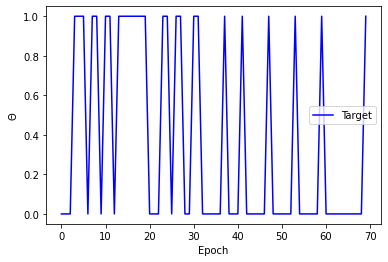

In [44]:
plt.figure()
ax=plt.gca()
ax.plot(np.array(accuracy),label='Target',c='b')
#     ax.plot(np.array(accuracy)[:,1][::10],label='Non-Target',c='r')
ax.set_xlabel('Epoch')
ax.set_ylabel('$\Theta$')
# ax.set_ylim([3e-6,])
plt.legend()
plt.savefig(saveFig+'698nw_2582nj_working_memory_nback_'+loadReinf+'accuracy_time_'+b+'.pdf',format='pdf',dpi=300)

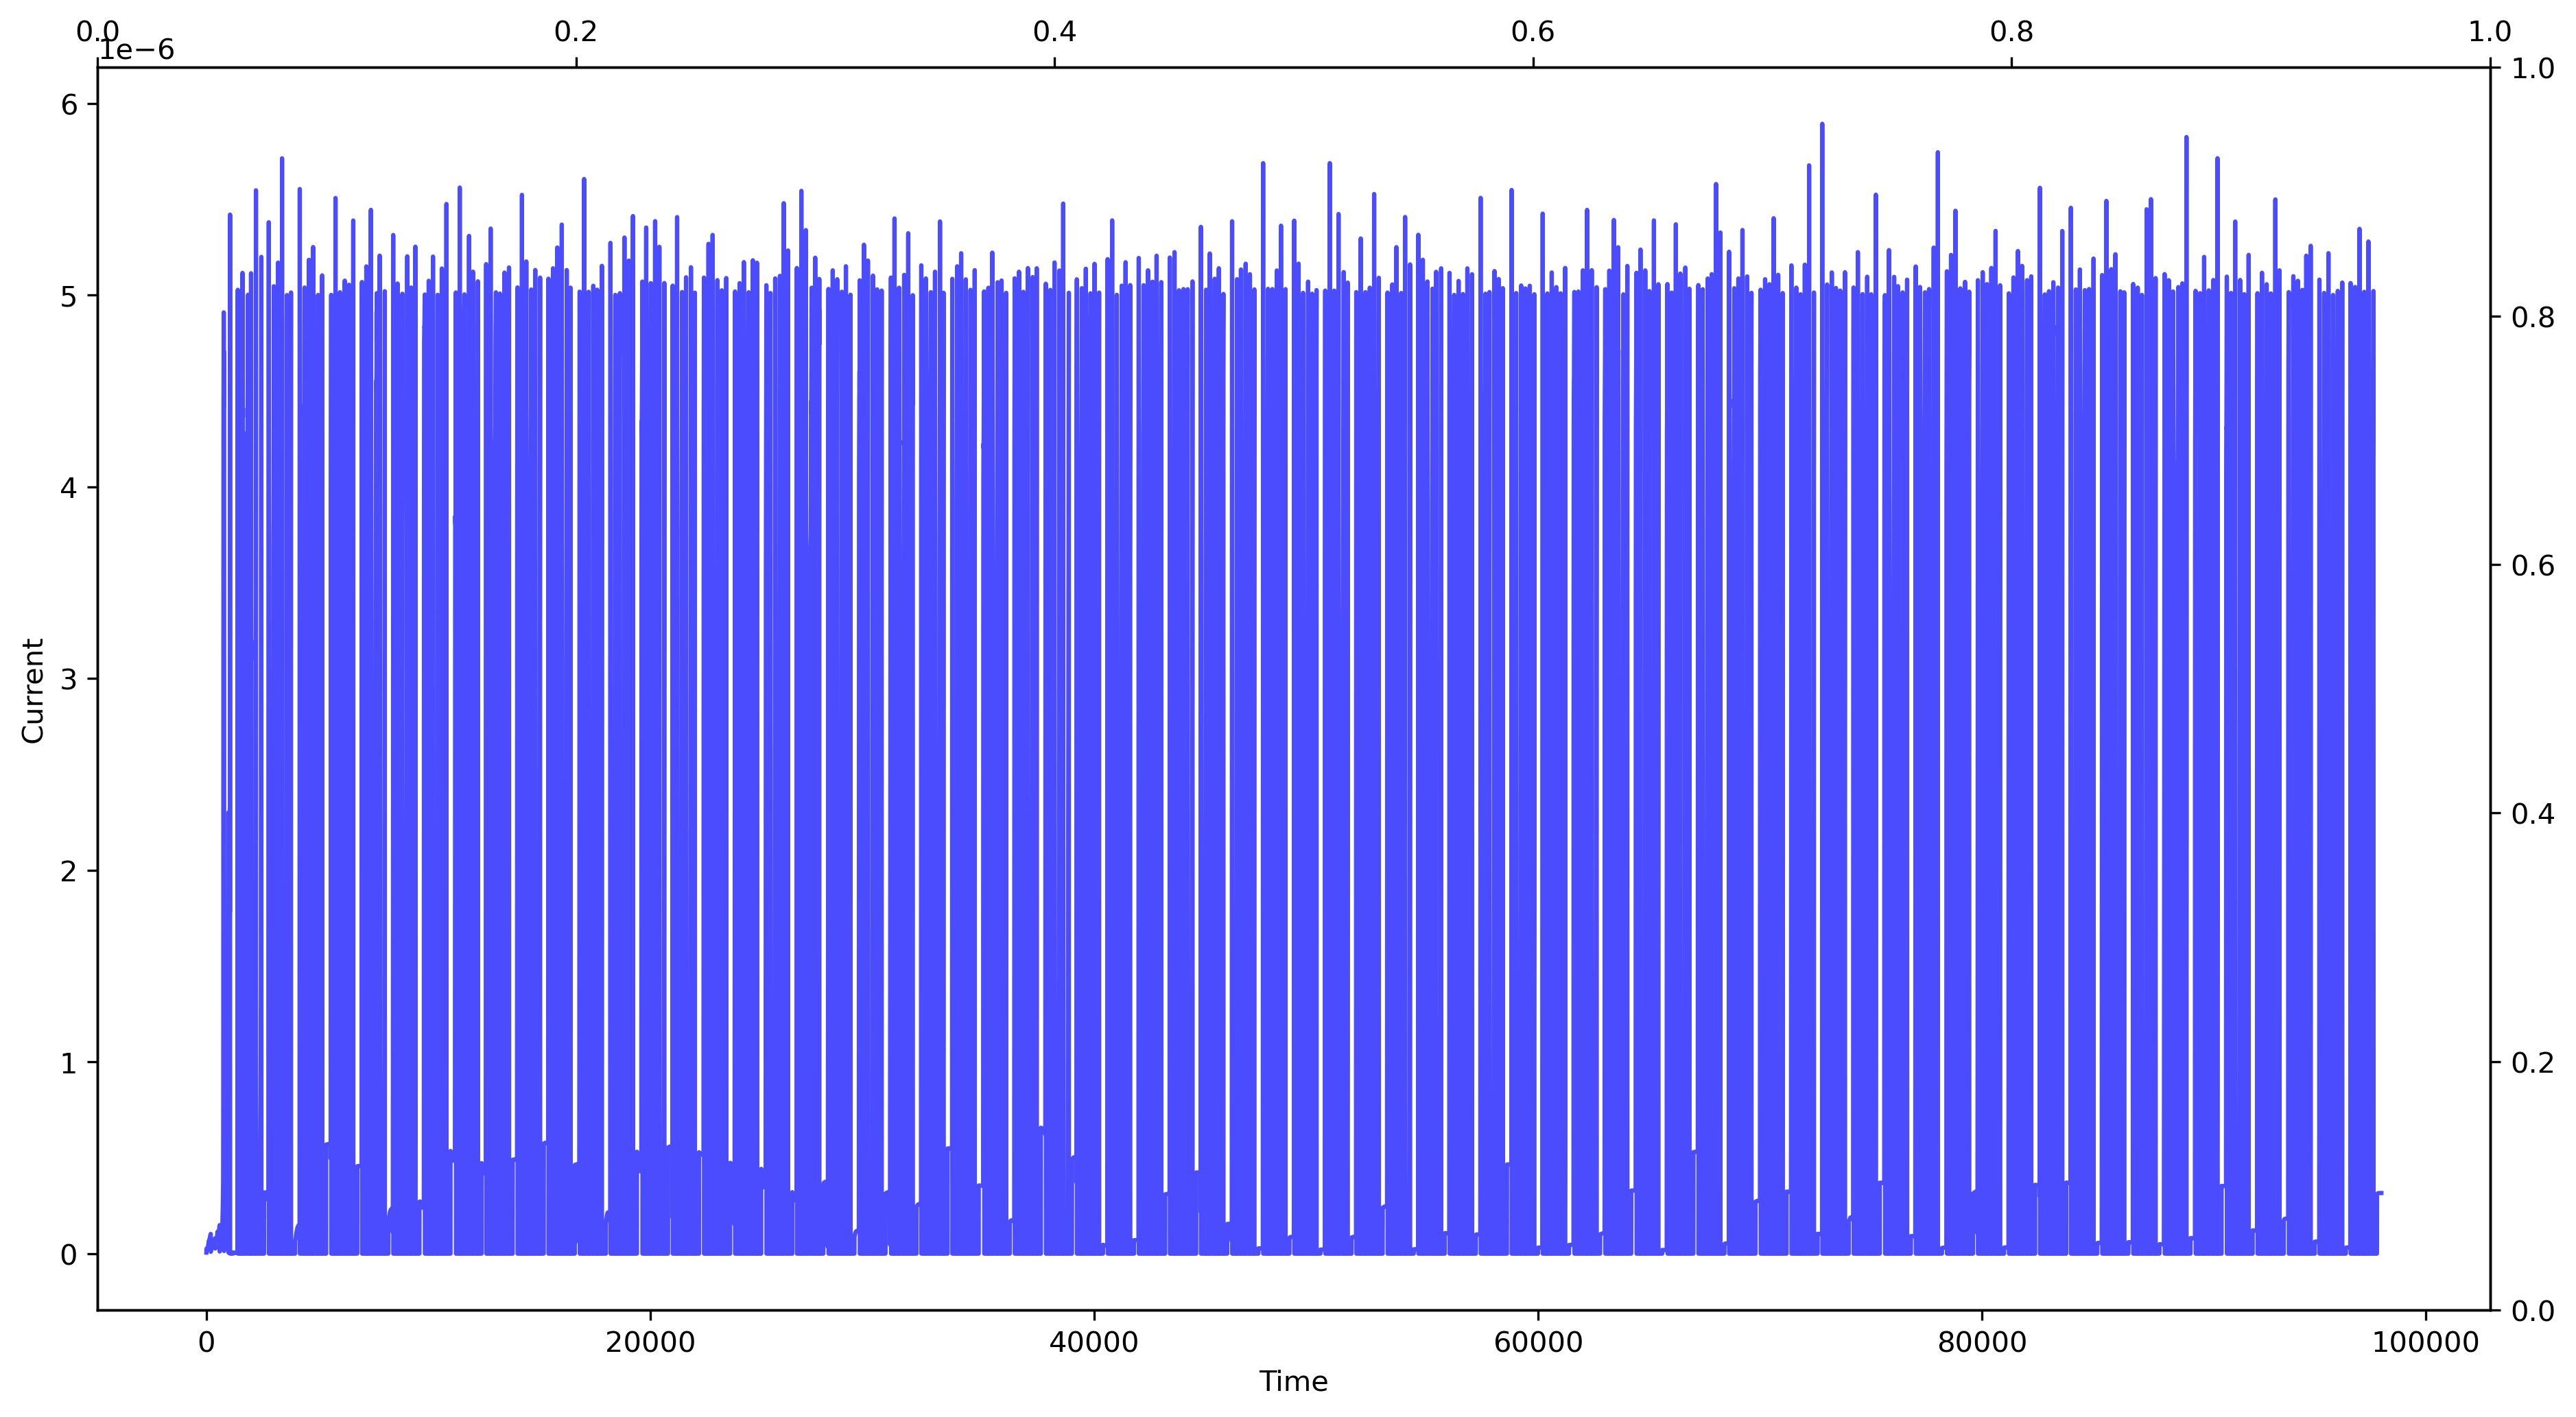

In [45]:
#Current Strength vs Accuracy:
import seaborn as sns
plt.rcParams['pdf.fonttype'] = 42


fig,ax = plt.subplots(1,1, figsize=(15, 8), dpi=300)
x=(drain1test)
p1=ax.plot(x,'b',alpha=0.7)
# p2=ax.plot((voltage[:,1]),'r',alpha=0.5)
# plt.legend([p1[0],p2[0]],['Target Drain'],loc='lower right',title='Current')


if nback == 7:
    xlimmax=830
    vlinesStep=40
    vlinesStart=30
    dotpos=2

if nback == 2:
#     xlimmax=1230
    vlinesStep=600
    vlinesStart=500
    dotpos=3
elif nback == 3:
    xlimmax=1630
    vlinesStep=80
    vlinesStart=70
    dotpos=4
    
# colrs=[]
# for val in targetsNew:
#     if val < 1:
#         colrs.append('C1')
#     else:
#         colrs.append('C2')    

# testColors=[]
# for i in colrs:
#     if i == 'C1':
#         testColors.append('b')
#     else:
#         testColors.append('r')
        
ax.set_xlabel('Time')
ax.set_ylabel('Current')
# ax.set_xlim([-600,24400])

# ax.vlines(range(vlinesStart,len(x),vlinesStep),np.min(drain1),np.max(drain1),linestyle='dashed',color='b',alpha=0.5)

ax2=ax.twinx().twiny()
# ax2.scatter(list(range(0,len(targets),1)),accuracy,c='b')
# ax2.set_ylim([-0.05,1.05])

# ax2.set_xticklabels(np.array(range(0,121,20)))#np.round(np.array(range(vlinesStart,len(x)-20,vlinesStep))/39)-1)

# testTimeVals=np.array(range(len(accuracy)))*dotpos+dotpos


# ax2.scatter(x=range(vlinesStart,len(x)-20,vlinesStep),y=accuracy,c=testColors)

# ax2.set_xlabel('Sample Num')
# ax2.set_ylabel('Accuracy')
# sns.scatterplot(x=testTimeVals,y='Accuracy',data=accuracy,hue=colrs[:-1],palette=['r','b'],ax=ax2)
# ax2.legend(title='Accuracy',loc='lower left')
# ax2.set_xlim([-20/20,(xlimmax+10)/20])
# ax2.set_ylabel('Accuracy')

# ax3=ax2.twinx()
# p1=ax3.plot(testTimeVals[:-1],count1plustest[:-1],color='c',marker='x')
# p2=ax3.plot(testTimeVals[:-1],count2plustest[:-1],color='m',marker='x')
# ax3.set_xlim([-20/20,1240/20])

# plt.vlines(range(3,testTimeVals.values[-1],3),0,1,linestyle='dashed',color='k',)
# if patternSize==2:
#     fig.savefig(saveFig+saveName+'.pdf',format='pdf',dpi=300)
# else:
fig.savefig(saveFig+'698w_2582j_current_time_accuracy_nback_random_patterns_'+loadReinf+'_'+b+'.pdf',format='pdf',dpi=300)


In [46]:
drain1thresh=signal_expand(np.array(thresholds)[:,0],200)

In [47]:
np.where(drain1thresh>5e-6)[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

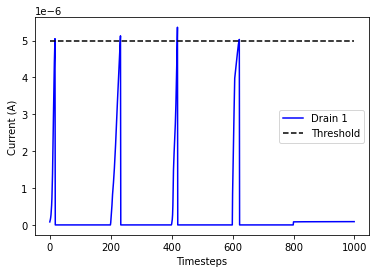

In [49]:
tstart=55000
tend=56000
# dur1=tend-np.where(drain1thresh>5e-6)[0][0]
# dur2=np.where(drain1thresh>5e-6)[0][0]-tstart
plt.plot(drain1[tstart:tend],label='Drain 1',c='b')
# plt.plot(drain2[tstart:tend],label='Drain 2')
plt.plot(drain1thresh[tstart:tend],c='black',linestyle='dashed',label='Threshold')
# plt.hlines(drain1thresh[dur2],0,dur2,colors='black',linestyles='dashed',label='Threshold')
# plt.hlines(drain1thresh[dur1],0,dur1,colors='black',linestyles='dashed',label='Threshold')

ax=plt.gca()
start, end = ax.get_xlim()
# plt.xticks(np.arange(start-start,end+start,np.abs(start-end)/6),labels=range(tstart,tend,int(dur/7)))
# ax.set_xticklabels(range(tstart-100,tend+100,int(dur/8)))
ax.set_xlabel('Timesteps')
ax.set_ylabel('Current (A)')
plt.legend()
plt.savefig(saveFig+'698w_2582j_current_time_oneEpoch_nback_random_patterns_t_'+str(tstart)+'_'+str(tend)+'_'+loadReinf+'_'+b+'.pdf',format='pdf')

In [50]:
nbackVals=np.argwhere(np.array(dataNoSim[7])==-1)-np.argwhere(np.array(dataNoSim[7])==0)

In [51]:
nbackVals=nbackVals.reshape(-1) #datastructure = [nbacks, experiments, epochs]

In [52]:
import pandas as pd
nbackAcc=pd.DataFrame({'nback':nbackVals,'Accuracy':accuracy})

In [53]:
numVals=[]
seAcc=[]
meanAcc=[]
for i in range(1,8):
    
    numVals.append((nbackAcc.where(nbackAcc['nback']==i)).count()[0])

    meanAcc.append((nbackAcc.where(nbackAcc['nback']==i)).mean(skipna=True)[1])
    seAcc.append((nbackAcc.where(nbackAcc['nback']==i)).std(skipna=True)[1]/np.sqrt(len(nbackAcc.where(nbackAcc['nback']==i))))

In [54]:
nbacks

[1, 2, 3, 4, 5, 6, 7]

Text(0.5, 1.0, 'noReinforcement')

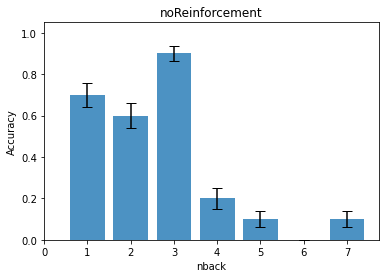

In [55]:
plt.rcParams['pdf.fonttype'] = 42

plt.bar(nbacks,meanAcc,yerr=seAcc,alpha=0.8, ecolor='black', capsize=5)
plt.xlabel('nback')
plt.ylabel('Accuracy')
ax=plt.gca()
ax.set_xticks(range(8))
ax.set_xticklabels(range(8))
ax.set_ylim([0,1.05])
plt.title(loadReinf)
# plt.savefig(saveFig+'698nw_2582nj_nback_working_memory_no_reinforcement_b0p1.pdf',format='pdf')


## FUNCTIONAL CONNECTIVITY

In [56]:
sys.path.append('/import/silo2/aloe8475/Documents/CODE/aux_functions/') #point to edamame locally

from matplotlib import animation
from matplotlib import colorbar as clbr
from PIL import Image

from matplotlib import rcParams
from create_colormap import get_continuous_cmap,hex_to_rgb,rgb_to_dec

#Functions:
def getWeightedGraph(adjMat,jC,jV,jF,edgeList,numWires,time,edge_mode):#, this_TimeStamp = 0):
#     edgeList = network['edge_list']
    adjMat = np.zeros((numWires, numWires))
#     set_trace()
    if edge_mode=='conductance':
        adjMat[edgeList[:,0], edgeList[:,1]] = jC[time,:]#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
        adjMat[edgeList[:,1], edgeList[:,0]] = jC[time,:]#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
        maxWeights=np.max(jC)

    elif edge_mode=='current':
        adjMat[edgeList[:,0], edgeList[:,1]] = jV[time,:]*jC[time,:]
        adjMat[edgeList[:,1], edgeList[:,0]] = jV[time,:]*jC[time,:]
        maxWeights=np.max(jV*jC)
        
        
    elif edge_mode=='filament':
        adjMat[edgeList[:,0], edgeList[:,1]] = jF[time,:]
        adjMat[edgeList[:,1], edgeList[:,0]] = jF[time,:]
        
    WeightedGraph = nx.from_numpy_array(adjMat)
    WeightedGraph=nx.DiGraph.to_undirected(WeightedGraph)
    
    return WeightedGraph

def image_draw_voltage(time,cmap,maxWeights,minWeights):
    ax.clear() 
    pos=nx.kamada_kawai_layout(g)
           
    #ALON'S CODE:    
    node_weight=sim.wireVoltage[time]

    pos=nx.kamada_kawai_layout(g)
    nodeList=g.nodes
    numWires=g.number_of_nodes()

    h=nx.draw_networkx_nodes(g,pos=pos,node_color=node_weight,cmap=cmap,node_size=50,ax=ax)

    h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color='grey')
    # nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='g',node_size=50,ax=ax)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[1]],node_color='r',node_size=10,ax=ax)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[0]],node_color='b',node_size=10,ax=ax)
    ax.set_title(str(time))
    
import matplotlib.colors as clrs

def image_draw_current_filament(time,edge_mode,edge_weight,cmap,maxWeights,minWeights):
    ax.clear() 
#     pos=nx.kamada_kawai_layout(g)
        
    #RUOMIN'S CODE:
#     draw_graph(sim,time,edge_mode=edge_mode,edge_weight=edge_weight,edge_colorbar=False,node_size=30,figsize=(10,8),edge_cmap=cmap,with_labels=False,norm=True,ax=ax,maxWeight=maxWeights,minWeight=minWeights)

    #ALON'S CODE:    
    
#     edge_mode=animationType
#     edgeList=sim.connectivity.edge_list
#     numWires=g.number_of_nodes()
#     G=getWeightedGraph(sim,edgeList,numWires,time,edge_mode)
    
    pos=nx.kamada_kawai_layout(g)
    edgeList=sims[0].connectivity.edge_list
    numWires=g.number_of_nodes()
    G=getWeightedGraph(adjMat,jC,jV,jF,edgeList,numWires,time,animationType)#, this_TimeStamp = 0):

    edge_weights=nx.get_edge_attributes(G,'weight')
#     G.remove_edges_from((e for e, w in edge_weights.items() if w <1e-)) 
    
    edges=G.edges()
    weights=[G[u][v]['weight'] for u,v in edges]
    
    if animationType=='filament':
        logVal=1e-7
    else:
        logVal=1e-7
    Q
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=clrs.SymLogNorm(logVal,base=10,vmin=minWeights, vmax=maxWeights))
    sm.set_array([])
    normweights=sm.norm(weights).data
    if len(normweights)==0:
        normweights=np.zeros(g.number_of_edges())
    
    normMin=sm.norm(minWeights)
    normMax=sm.norm(maxWeights)
    h=nx.draw_networkx_nodes(g,pos=pos,node_color='grey',node_size=20,ax=ax)
    
    thisTarget=int(targetValsTime[time])
    x=(alltargets==thisTarget)
    #     h.set_zorder(1)
    h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color=normweights,width=2,edge_cmap=cmap,edge_vmin=normMin,edge_vmax=normMax,alpha=0.7)
    if thisTarget == 1:
        nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='k',node_size=100,ax=ax)
        nx.draw_networkx_nodes(g,pos=pos,nodelist=list(activeSources[np.where(x)[0][0]+1]),node_color='g',node_size=100,ax=ax)

        if time in testTimes:
            nx.draw_networkx_nodes(g,pos=pos,nodelist=drain_pool,node_color='r',node_size=100,ax=ax)
        else:
            nx.draw_networkx_nodes(g,pos=pos,nodelist=[drain_pool[0]],node_color='r',node_size=100,ax=ax)
            nx.draw_networkx_nodes(g,pos=pos,nodelist=list(drain_pool[1:]),node_color='k',node_size=100,ax=ax)
    else:
        nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='k',node_size=100,ax=ax)
        nx.draw_networkx_nodes(g,pos=pos,nodelist=list(activeSources[np.where(x)[0][0]+1]),node_color='g',node_size=100,ax=ax) #need to write this better

        if time in testTimes:
            nx.draw_networkx_nodes(g,pos=pos,nodelist=drain_pool,node_color='r',node_size=100,ax=ax)
        else:
            nx.draw_networkx_nodes(g,pos=pos,nodelist=[drain_pool[thisTarget-1]],node_color='r',node_size=100,ax=ax)
            nx.draw_networkx_nodes(g,pos=pos,nodelist=list(np.hstack(np.array([drain_pool[:thisTarget-1],drain_pool[thisTarget:]]))),node_color='k',node_size=100,ax=ax)


    
    # shift position a little bit
    shift = [-0.1, 0]
    shifted_pos ={node: node_pos + shift for node, node_pos in pos.items()}
#     set_trace()
    # Just some text to print in addition to node ids  
    
    labels = {}
    for node in g.nodes():
        if node in drain_pool:
        #set the node name as the key and the label as its value 
            labels[node] = node
#     labels[1] = 'Drain 1'
#     labels[2] = 'Drain 2'
    nx.draw_networkx_labels(g, shifted_pos, labels=labels, horizontalalignment="left")
    if time in testTimes:
        timeVals='Testing'
    else:
        timeVals='Training'
    
    ax.set_title('T = ' + str(time)+ ' | ' + timeVals + ' | Target ' + str(targetValsTime[time]))

    
#New loadmat:
import scipy.io as spio

def loadmatNew(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict


In [57]:
#FUNCTIONAL CONNECTIVITY:
nw=loadmat('/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00698_nj_02582_seed_002_avl_10.00_disp_01.00_lx_75.00_ly_75.00')

# nw=loadmat(fileName)
g=nx.from_numpy_array(nw['adj_matrix'])
adjMat=nw['adj_matrix']

num_drain_training=1
num_drain_testing=7
numSources=9
numSamples=70
nbacks         = [num_drain_testing]
nback=nbacks[0]
numDT=200

# reinforcement=True #do we want to activate reinforcement?

connectivity,sources,drain_pool,nwSize,nwJunctions=buildNetworks(fileName,True,num_drain_testing,numSources)

Network 698 Loaded


In [58]:
nwJunctions=nw['number_of_junctions'][0][0]
nwWires=nw['number_of_wires'][0][0]

In [59]:
#combine all sim voltages, conductance and filament together
jV=[]
jF=[]
jC=[]
activeSources=[]
for i in range(len(sims)):
    jV.append(sims[i].junctionVoltage)   
    jF.append(sims[i].filamentState) #Junction Filament Negative
    jC.append(sims[i].junctionConductance)
    activeSources.append(sims[i].sources)

In [60]:
jV=np.array(jV).reshape(len(jV)*numDT,nwJunctions) 
jF=np.array(jF).reshape(len(jF)*numDT,nwJunctions)
jC=np.array(jC).reshape(len(jC)*numDT,nwJunctions)


In [61]:
targetValsTime=np.array(dataNoSim[4]).reshape(-1)
alltargets=np.array(dataNoSim[4])[:,0].reshape(-1)
counts=[]
for i in range(numSamples):
    counts.append(i)
    
    
TestTimeStart=((np.array(counts)+1)*numDT*(nback+1))-numDT
TestTimeEnd=((np.array(counts)+1))*numDT*(nback+1)-1
TrainTimeStart=((np.array(counts)+1)*numDT*(nback+1))-numDT*(nback+1)
TrainTimeEnd=((np.array(counts)+1)*numDT*(nback+1))-numDT-1


vals=[]
for i in range(len(counts)):
    vals.append(np.arange(TestTimeStart[i],TestTimeEnd[i]))
testTimes=np.array(vals).reshape(-1)


xlims=[TrainTimeStart[0],TrainTimeEnd[-1]]


In [62]:
# plt.close('all')
rcParams['animation.embed_limit'] = 2**64


edge_mode='custom'
animationType = 'conductance'


if animationType =='current':
    minWeights=0
    jI=np.array(jV*jC)
    edge_weight = jI
    maxWeights=np.max(jI)
    cmap=plt.cm.magma_r
elif animationType== 'conductance':
    minWeights=0
    maxWeights=np.max(jC)
#     cmap=plt.cm.coolwarm
    colorlist=  ["a0051f","b8323d","cf5f5a","e68c78","fdb995","e4c5bc","cad0e3","cddff1","cfe6f8","d0edff"]#["710000","fad39d","e8f5fd","003470"]

    colorlist.reverse()
    cmap=get_continuous_cmap(colorlist) #hexlist

    edge_weight=jC
elif animationType== 'filament':
    minWeights=0
    maxWeights=np.max(jF)
    colorlist=["950700","c93a28","fd6c50","fb986a","f7c59f","efd6b8","e6e6d0"]


    colorlist.reverse()
    cmap=get_continuous_cmap(colorlist) #hexlist
#     cmap=plt.cm.Pastel1
    edge_weight=jF
    #binary threshold (only show above or below a certain value)

times=[600, 1400, 55000, 55800, 108800,110200]

for time in tqdm(times):
    
    f,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},frameon=False, figsize=(10, 8), dpi=300)
    canvas_width, canvas_height = f.canvas.get_width_height()
    ax.axis('off')
    cax.axis('off')

    # clrplt=np.linspace(minWeights,maxWeights,1000).reshape(1000,1)
    # img=cax.imshow(clrplt,cmap=cmap,norm=clrs.LogNorm())
    # cax.set_visible(False)
    # formatter = LogFormatter(10, labelOnlyBase=True) 
    # norm=clrs.SymLogNorm(1,base=10,vmin=minWeights,vmax=maxWeights)
    # cb1=clbr.ColorbarBase(cax,cmap=cmap,norm=norm)


    pos=nx.kamada_kawai_layout(g)
    edgeList=sims[0].connectivity.edge_list
    numWires=g.number_of_nodes()
    G=getWeightedGraph(adjMat,jC,jV,jF,edgeList,numWires,time,animationType)#, this_TimeStamp = 0):

    # edge_weights=nx.get_edge_attributes(G,'weight')
    # G.remove_edges_from((e for e, w in edge_weights.items() if w <1e-10)) 

    edges=G.edges()
    weights=[G[u][v]['weight'] for u,v in edges]

    # normweights = (np.array(weights)-minWeights) / (maxWeights - minWeights)
    # weights = [cmap(color_normal(e)) for e in weights]
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=clrs.SymLogNorm(1e-7,base=10,vmin=minWeights, vmax=maxWeights))
    sm.set_array([])

    normweights=sm.norm(weights).data
    normMin=sm.norm(minWeights)
    normMax=sm.norm(maxWeights)

    h=nx.draw_networkx_nodes(g,pos=pos,node_color='grey',node_size=20,ax=ax)

    # h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color=normweights,width=2,edge_cmap=cmap,edge_vmin=normMin,edge_vmax=normMax)

    thisTarget=int(targetValsTime[time])
    x=(alltargets==thisTarget)
    #     h.set_zorder(1)
    h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color=normweights,width=2,edge_cmap=cmap,edge_vmin=normMin,edge_vmax=normMax,alpha=0.6)
    if thisTarget == 1:
        nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='k',node_size=100,ax=ax)
        nx.draw_networkx_nodes(g,pos=pos,nodelist=list(activeSources[np.where(x)[0][0]+1]),node_color='g',node_size=100,ax=ax)

        if time in testTimes:
            nx.draw_networkx_nodes(g,pos=pos,nodelist=drain_pool,node_color='r',node_size=100,ax=ax)
        else:
            nx.draw_networkx_nodes(g,pos=pos,nodelist=[drain_pool[0]],node_color='r',node_size=100,ax=ax)
            nx.draw_networkx_nodes(g,pos=pos,nodelist=list(drain_pool[1:]),node_color='k',node_size=100,ax=ax)
    else:
        nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='k',node_size=100,ax=ax)

    #     set_trace()

        nx.draw_networkx_nodes(g,pos=pos,nodelist=list(activeSources[np.where(x)[0][0]+1]),node_color='g',node_size=100,ax=ax) #need to write this better

        if time in testTimes:
            nx.draw_networkx_nodes(g,pos=pos,nodelist=drain_pool,node_color='r',node_size=100,ax=ax)
        else:
            nx.draw_networkx_nodes(g,pos=pos,nodelist=[drain_pool[thisTarget-1]],node_color='r',node_size=100,ax=ax)
            nx.draw_networkx_nodes(g,pos=pos,nodelist=list(np.hstack(np.array([drain_pool[:thisTarget-1],drain_pool[thisTarget:]]))),node_color='k',node_size=100,ax=ax)




    if time in testTimes:
        timeVals='Testing'
    else:
        timeVals='Training'

    ax.set_title('T = ' + str(time)+ ' | ' + timeVals + ' | Target ' + str(targetValsTime[time]))

    cbar = plt.colorbar(sm, ax=ax,
                        fraction = 0.05, label=animationType)


    print(loadReinf+'_'+b)
    plt.savefig(saveFig+str(nwWires)+'nw_'+str(nwJunctions)+'nj_nback_WorkingMemory_'+loadReinf+'_7drains_3x3_'+b+'_t'+str(time)+timeVals+'.pdf',format='pdf')
    with open(dataLoc+'/Sim Results/working memory nback/'+str(nwWires)+'nw_'+str(nwJunctions)+'nj_nback_WorkingMemory_'+loadReinf+'_7drains_3x3_'+b+'_JC_t'+str(time)+timeVals+'.pkl', 'wb') as f1:
        pickle.dump(weights, f1) 
    print('Saved')
    
    plt.close(f)

  0%|          | 0/6 [00:00<?, ?it/s]

noReinforcement_b0p5
Saved
noReinforcement_b0p5
Saved
noReinforcement_b0p5
Saved
noReinforcement_b0p5
Saved
noReinforcement_b0p5
Saved
noReinforcement_b0p5
Saved


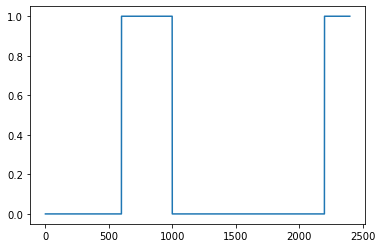

In [66]:
plt.plot((targetValsTime==1)[108000:110400])

In [201]:
anim1 = animation.FuncAnimation(f, image_draw_current_filament, 
                               frames=range(xlims[0],xlims[1],1)[::200], 
                               interval=20, 
                               repeat=False,fargs=(edge_mode,edge_weight,cmap,maxWeights,minWeights))

In [217]:
#Draw Example Time:
plt.figure()
time = 1001
image_draw_current_filament(time,edge_mode,edge_weight,cmap,maxWeights,minWeights)
plt.show()

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [240]:
plt.close('all')

2022-06-15 15:36:26,098:INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2022-06-15 15:36:26,102:INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3000x2400 -pix_fmt rgba -r 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 698nw_2582nj_nback_WorkingMemory_noReinforcement_3x3_7drains_b2_conductance_t0_111799.mp4


Saving frame 0 of 559
Saving frame 1 of 559
Saving frame 2 of 559
Saving frame 3 of 559
Saving frame 4 of 559
Saving frame 5 of 559
Saving frame 6 of 559
Saving frame 7 of 559
Saving frame 8 of 559
Saving frame 9 of 559
Saving frame 10 of 559
Saving frame 11 of 559
Saving frame 12 of 559
Saving frame 13 of 559
Saving frame 14 of 559
Saving frame 15 of 559
Saving frame 16 of 559
Saving frame 17 of 559
Saving frame 18 of 559
Saving frame 19 of 559
Saving frame 20 of 559
Saving frame 21 of 559
Saving frame 22 of 559
Saving frame 23 of 559
Saving frame 24 of 559
Saving frame 25 of 559
Saving frame 26 of 559
Saving frame 27 of 559
Saving frame 28 of 559
Saving frame 29 of 559
Saving frame 30 of 559
Saving frame 31 of 559
Saving frame 32 of 559
Saving frame 33 of 559
Saving frame 34 of 559
Saving frame 35 of 559
Saving frame 36 of 559
Saving frame 37 of 559
Saving frame 38 of 559
Saving frame 39 of 559
Saving frame 40 of 559
Saving frame 41 of 559
Saving frame 42 of 559
Saving frame 43 of 55

Saving frame 346 of 559
Saving frame 347 of 559
Saving frame 348 of 559
Saving frame 349 of 559
Saving frame 350 of 559
Saving frame 351 of 559
Saving frame 352 of 559
Saving frame 353 of 559
Saving frame 354 of 559
Saving frame 355 of 559
Saving frame 356 of 559
Saving frame 357 of 559
Saving frame 358 of 559
Saving frame 359 of 559
Saving frame 360 of 559
Saving frame 361 of 559
Saving frame 362 of 559
Saving frame 363 of 559
Saving frame 364 of 559
Saving frame 365 of 559
Saving frame 366 of 559
Saving frame 367 of 559
Saving frame 368 of 559
Saving frame 369 of 559
Saving frame 370 of 559
Saving frame 371 of 559
Saving frame 372 of 559
Saving frame 373 of 559
Saving frame 374 of 559
Saving frame 375 of 559
Saving frame 376 of 559
Saving frame 377 of 559
Saving frame 378 of 559
Saving frame 379 of 559
Saving frame 380 of 559
Saving frame 381 of 559
Saving frame 382 of 559
Saving frame 383 of 559
Saving frame 384 of 559
Saving frame 385 of 559
Saving frame 386 of 559
Saving frame 387

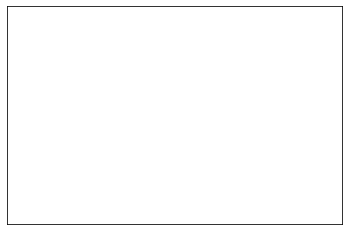

In [202]:
#MP4
currentPath=os.getcwd()
FFwriter = animation.FFMpegWriter()
os.chdir(saveFig)
# if ManualSources:
anim1.save(str(nwWires)+'nw_'+str(nwJunctions)+'nj_nback_WorkingMemory_'+loadReinf+'_3x3_7drains_'+b+'_'+animationType+'_t'+str(xlims[0])+'_'+str(xlims[1])+'.mp4', fps=10,
          progress_callback = lambda i, n: print(f'Saving frame {i} of {n}'),)
# else:
#     anim1.save('nback_explore_'+animationType+'_trial9_t'+str(xlims[0])+'_'+str(xlims[1])+'_magmacmap.mp4', fps=10,
#               progress_callback = lambda i, n: print(f'Saving frame {i} of {n}'),)
os.chdir(currentPath)


In [63]:
#Junction Conductance:
jCnoReinforcement=[]
jCwReinforcement=[]
times=[1400, 55800, 110200]
for time in times:
    #LOAD 
    with open(dataLoc+'/Sim Results/working memory nback/'+str(nwWires)+'nw_'+str(nwJunctions)+'nj_nback_WorkingMemory_noReinforcement_7drains_3x3_'+b+'_JC_t'+str(time)+'Testing.pkl', 'rb') as f:
        jCnoReinforcement.append(pickle.load(f)) 
    with open(dataLoc+'/Sim Results/working memory nback/'+str(nwWires)+'nw_'+str(nwJunctions)+'nj_nback_WorkingMemory_wReinforcement_7drains_3x3_'+b+'_JC_t'+str(time)+'Testing.pkl', 'rb') as f:
        jCwReinforcement.append(pickle.load(f)) 
        
jCnoReinforcement=np.array(jCnoReinforcement)
jCwReinforcement=np.array(jCwReinforcement)

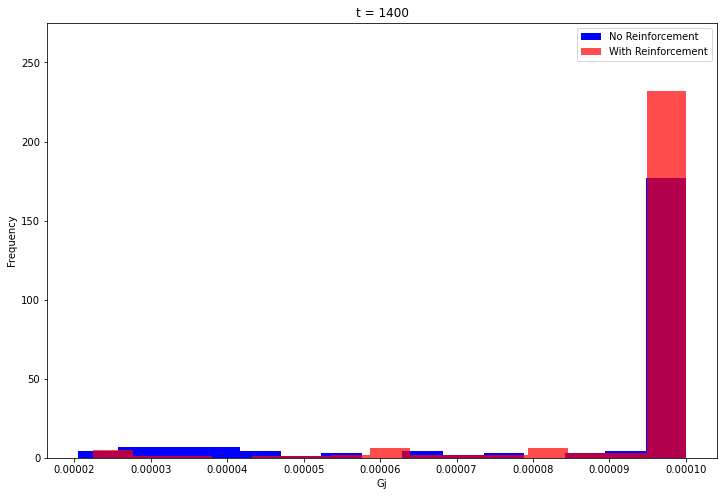

In [71]:
plt.rcParams['pdf.fonttype'] = 42

whichEpoch = 0


reducedJCnoReinf=jCnoReinforcement[whichEpoch][jCnoReinforcement[whichEpoch]>2e-5]
reducedJCwReinf=jCwReinforcement[whichEpoch][jCwReinforcement[whichEpoch]>2e-5]

plt.figure(figsize=(12,8))
plt.hist(reducedJCnoReinf,facecolor='b',label='No Reinforcement',bins=15)
plt.hist(reducedJCwReinf,facecolor='r',alpha=0.7,label='With Reinforcement',bins=15)
plt.title('t = '+str(times[whichEpoch]))
plt.legend()
plt.xlabel('Gj')
plt.ylabel('Frequency')
plt.ylim([0,275])
plt.savefig(saveFig+str(nwWires)+'nw_'+str(nwJunctions)+'nj_nback_WorkingMemory_'+b+'_JC_hist_'+str(times[whichEpoch])+'.pdf',format='pdf',dpi=300)